In [81]:
# ===== 모델 초기화 (Linux NVIDIA GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# NVIDIA GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ NVIDIA GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # GPU 메모리 동적 할당 (필요한 만큼만 사용)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 메모리 동적 할당 활성화됨!")
    except RuntimeError as e:
        print(f"⚠️ 메모리 설정 실패: {e}")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# GPU 연산 테스트 (에러 발생시 CPU로 폴백)
print("\n=== GPU 연산 테스트 ===")
try:
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print(f"✅ GPU 연산 테스트 완료: shape = {c.shape}")
except Exception as e:
    print(f"⚠️ GPU 연산 실패, CPU 사용: {e}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 GPU 초기화 완료")


TensorFlow 버전: 2.15.0
✅ NVIDIA GPU 발견: 1개
   - /physical_device:GPU:0
✅ GPU 메모리 동적 할당 활성화됨!

=== GPU 연산 테스트 ===
✅ GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [82]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_gpu'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.15.0
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [83]:
# ===== 1) 설정 =====
# 🔧 Linux 환경 경로
DATA_PATH = "/home/wza/YU_mobile_kotlin/phishing/phishing_data_tflite_ready.csv"
TARGET_COL = "status"
EMBEDDING_DIM = 32  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 16  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.0001  # 로스 폭발 방지: 0.001 → 0.0001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=32, 배치 크기=16, 에폭=200


In [84]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 72)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors', 

In [85]:
# ===== 3) 피처 및 레이블 분리 (50:50 균형 분할) =====
# 원본 데이터 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
# 모델 출력도 동일: 0에 가까우면 정상, 1에 가까우면 피싱

print(f"피처 개수: {len(df_work.columns) - 1}")
print(f"전체 데이터 shape: {df_work.shape}")
print(f"\n원본 레이블 분포:")
print(f"  - 정상(0): {(df_work[TARGET_COL]==0).sum()}")
print(f"  - 피싱(1): {(df_work[TARGET_COL]==1).sum()}")

# ===== 50:50 균형 분할 함수 =====
def split_class(class_df, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    shuffled = class_df.sample(frac=1, random_state=seed)
    shuffled = shuffled.sample(frac=1, random_state=seed+1)
    shuffled = shuffled.sample(frac=1, random_state=seed+2)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (shuffled.iloc[:train_end], 
            shuffled.iloc[train_end:val_end], 
            shuffled.iloc[val_end:])

# 클래스별로 분리
df_legit = df_work[df_work[TARGET_COL] == 0]  # 정상
df_phish = df_work[df_work[TARGET_COL] == 1]  # 피싱

# 각 클래스별로 60/20/20 분할
legit_train, legit_val, legit_test = split_class(df_legit, seed=RANDOM_SEED)
phish_train, phish_val, phish_test = split_class(df_phish, seed=RANDOM_SEED)

# 합치기 (각 세트에서 50:50 비율 유지)
train_df = pd.concat([legit_train, phish_train]).sample(frac=1, random_state=RANDOM_SEED)
val_df = pd.concat([legit_val, phish_val]).sample(frac=1, random_state=RANDOM_SEED)
test_df = pd.concat([legit_test, phish_test]).sample(frac=1, random_state=RANDOM_SEED)

# 피처와 레이블 분리
X_train = train_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = train_df[TARGET_COL].values.astype(np.float32)

X_val = val_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = val_df[TARGET_COL].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = test_df[TARGET_COL].values.astype(np.float32)

# 결과 출력
print(f"\n===== 50:50 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상:{(y_train==0).sum()}, 피싱:{(y_train==1).sum()}")
print(f"Val:   {X_val.shape} - 정상:{(y_val==0).sum()}, 피싱:{(y_val==1).sum()}")
print(f"Test:  {X_test.shape} - 정상:{(y_test==0).sum()}, 피싱:{(y_test==1).sum()}")

# 비율 확인
print(f"\n===== 각 세트의 피싱 비율 =====")
print(f"Train 피싱 비율: {y_train.mean()*100:.1f}%")
print(f"Val 피싱 비율:   {y_val.mean()*100:.1f}%")
print(f"Test 피싱 비율:  {y_test.mean()*100:.1f}%")

피처 개수: 71
전체 데이터 shape: (11481, 72)

원본 레이블 분포:
  - 정상(0): 5740
  - 피싱(1): 5741

===== 50:50 균형 분할 결과 =====
Train: (6888, 71) - 정상:3444, 피싱:3444
Val:   (2296, 71) - 정상:1148, 피싱:1148
Test:  (2297, 71) - 정상:1148, 피싱:1149

===== 각 세트의 피싱 비율 =====
Train 피싱 비율: 50.0%
Val 피싱 비율:   50.0%
Test 피싱 비율:  50.0%


In [88]:
# ===== 4) 데이터 전처리 (RobustScaler만 적용) =====
# ✅ 이상치에 민감한 피처: RobustScaler (중앙값/IQR 기반) - 이상치에 더 강함
# ✅ 나머지 피처: 정규화 없음 (원본 그대로 사용 - 모델이 원래 스케일 직접 학습)
# Android에서는 RobustScaler 파라미터만 사용해 전처리 필요

from sklearn.preprocessing import RobustScaler

# RobustScaler를 적용할 피처 목록 (이상치가 많은 피처들)
robust_cols = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_and',
    'nb_eq',
    'nb_underscore',
    'nb_percent',
    'nb_slash',
    'nb_colon',
    'nb_semicolumn',
    'nb_space',
    'nb_com',
    'ratio_digits_url',
    'ratio_digits_host',
    'nb_redirection',
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path',
    'phish_hints',
    'nb_extCSS',
    'ratio_extRedirection',
    'ratio_extErrors',
]

# 피처 인덱스 매핑
feature_names = [col for col in df_work.columns if col != TARGET_COL]
robust_indices = [feature_names.index(col) for col in robust_cols if col in feature_names]
raw_indices = [i for i in range(len(feature_names)) if i not in robust_indices]

print(f"RobustScaler 적용 피처: {len(robust_indices)}개")
print(f"정규화 없음 (원본 그대로): {len(raw_indices)}개")

# RobustScaler 생성
robust_scaler = RobustScaler()

# 스케일링 수행
X_train_scaled = X_train.copy().astype(np.float32)
X_val_scaled = X_val.copy().astype(np.float32)
X_test_scaled = X_test.copy().astype(np.float32)

# RobustScaler 적용만 (중앙값 기반 - 이상치 영향 적음)
X_train_scaled[:, robust_indices] = robust_scaler.fit_transform(X_train[:, robust_indices]).astype(np.float32)
X_val_scaled[:, robust_indices] = robust_scaler.transform(X_val[:, robust_indices]).astype(np.float32)
X_test_scaled[:, robust_indices] = robust_scaler.transform(X_test[:, robust_indices]).astype(np.float32)

# raw_indices는 그대로 두기 (정규화 안 함)

print("\n데이터 전처리 완료 (RobustScaler만 적용)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 평균: {X_train_scaled.mean():.4f}, 표준편차: {X_train_scaled.std():.4f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

# Android에서 사용할 파라미터 저장
scaler_params = {
    'type': 'robust_only',
    'robust_cols': robust_cols,
    'robust_center': robust_scaler.center_.tolist(),
    'robust_scale': robust_scaler.scale_.tolist(),
    'raw_cols': [feature_names[i] for i in raw_indices]
}

print(f"\n📊 Scaler 파라미터 (Android 전처리용):")
print(f"   RobustScaler: {len(robust_cols)}개 피처 (이상치에 강함)")
print(f"   원본 그대로: {len(raw_indices)}개 피처 (정규화 없음)")

RobustScaler 적용 피처: 31개
정규화 없음 (원본 그대로): 40개

데이터 전처리 완료 (RobustScaler만 적용)
Train 피처 범위: min=-2.00, max=124.00
Train 피처 평균: 0.2332, 표준편차: 1.0991
피처 개수: 71개

📊 Scaler 파라미터 (Android 전처리용):
   RobustScaler: 31개 피처 (이상치에 강함)
   원본 그대로: 40개 피처 (정규화 없음)


In [89]:
# ===== 5) 분류 모델 구축 (TFLite 친화적: 정규화 레이어 없음) =====
# ✅ Dense + ReLU + L2 regularization만 사용
# ✅ 입력은 RobustScaler만 적용 (40개 피처는 원본 그대로)
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]
L2_REG = 0.0001  # 로스 폭발 방지: 0.001 → 0.0001

encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')

# Encoder 블록 (정규화 레이어 없이 L2 regularization만 사용 - Dropout 제거)
# ⭐ TFLite 호환성: Dropout 제거 (TFLite에서 Dropout이 활성화 상태로 남을 수 있음)
x = layers.Dense(256, activation='relu', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense1')(encoder_input)

x = layers.Dense(128, activation='relu',
                 kernel_initializer='he_normal', 
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense2')(x)

x = layers.Dense(64, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense3')(x)

# 임베딩 레이어
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', 
                         kernel_regularizer=keras.regularizers.l2(L2_REG),
                         name='embedding')(x)

# Classification Head (Dropout 제거)
x = layers.Dense(32, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='classifier_dense1')(embedding)

x = layers.Dense(16, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='classifier_dense2')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 (TFLite 친화적: 정규화 레이어 없음) =====")
print("✅ Dense + ReLU + L2 regularization만 사용")
print("✅ 입력: RobustScaler 31개 피처 + 원본 40개 피처")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 (TFLite 친화적: 정규화 레이어 없음) =====
✅ Dense + ReLU + L2 regularization만 사용
✅ 입력: RobustScaler 31개 피처 + 원본 40개 피처
Model: "phishing_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 71)]              0         
                                                                 
 encoder_dense1 (Dense)      (None, 256)               18432     
                                                                 
 encoder_dense2 (Dense)      (None, 128)               32896     
                                                                 
 encoder_dense3 (Dense)      (None, 64)                8256      
                                                                 
 embedding (Dense)           (None, 32)                2080      
                                                                 
 classifier_dense1 (Dense)   (None, 32)                

In [90]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200
431/431 [==============================] - 3s 5ms/step - loss: 0.5873 - accuracy: 0.7741 - auc: 0.8570 - val_loss: 0.4322 - val_accuracy: 0.8619 - val_auc: 0.9325 - lr: 1.0000e-04
Epoch 2/200
431/431 [==============================] - 3s 5ms/step - loss: 0.5873 - accuracy: 0.7741 - auc: 0.8570 - val_loss: 0.4322 - val_accuracy: 0.8619 - val_auc: 0.9325 - lr: 1.0000e-04
Epoch 2/200
431/431 [==============================] - 2s 5ms/step - loss: 0.4025 - accuracy: 0.8734 - auc: 0.9408 - val_loss: 0.3600 - val_accuracy: 0.8990 - val_auc: 0.9570 - lr: 1.0000e-04
Epoch 3/200
431/431 [==============================] - 2s 5ms/step - loss: 0.4025 - accuracy: 0.8734 - auc: 0.9408 - val_loss: 0.3600 - val_accuracy: 0.8990 - val_auc: 0.9570 - lr: 1.0000e-04
Epoch 3/200
431/431 [==============================] - 2s 5ms/step - loss: 0.3558 - accuracy: 0.8946 - auc: 0.9565 - val_loss: 0.3444 - val_accuracy: 0.8998 - val_auc: 0.9616 - lr: 1.0000e-04
Epoch 4/200
431/431 [===================

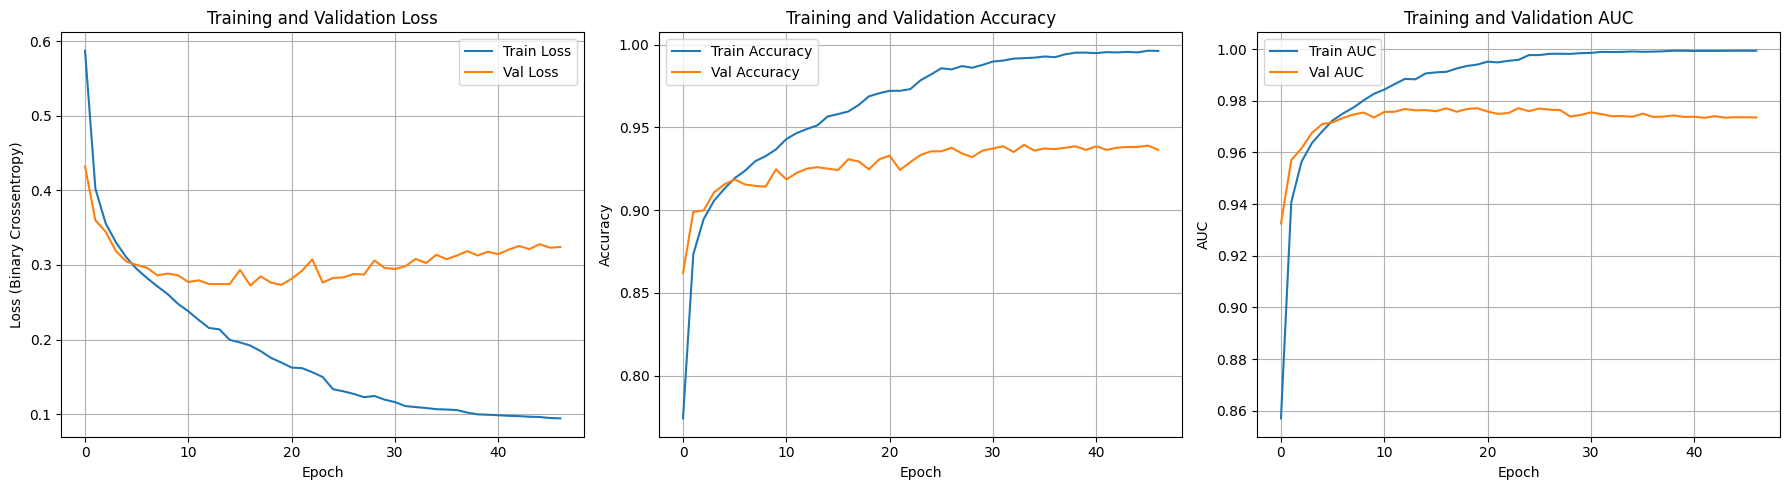

In [91]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [73]:
# ===== 8) 모델 평가 (Validation) =====
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)

print("===== Validation 세트 평가 결과 =====")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_binary = (pred_val > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_val, pred_val_binary, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Loss: 0.2569
Accuracy: 0.9429
AUC: 0.9828

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.93      0.96      0.94      1148
  Legitimate       0.96      0.93      0.94      1148

    accuracy                           0.94      2296
   macro avg       0.94      0.94      0.94      2296
weighted avg       0.94      0.94      0.94      2296



In [74]:
# ===== 9) 모델 평가 (Test) =====
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)

print("===== Test 세트 평가 결과 =====")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_binary = (pred_test > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_binary, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Loss: 0.2802
Accuracy: 0.9382
AUC: 0.9792

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.93      0.95      0.94      1148
  Legitimate       0.95      0.92      0.94      1149

    accuracy                           0.94      2297
   macro avg       0.94      0.94      0.94      2297
weighted avg       0.94      0.94      0.94      2297



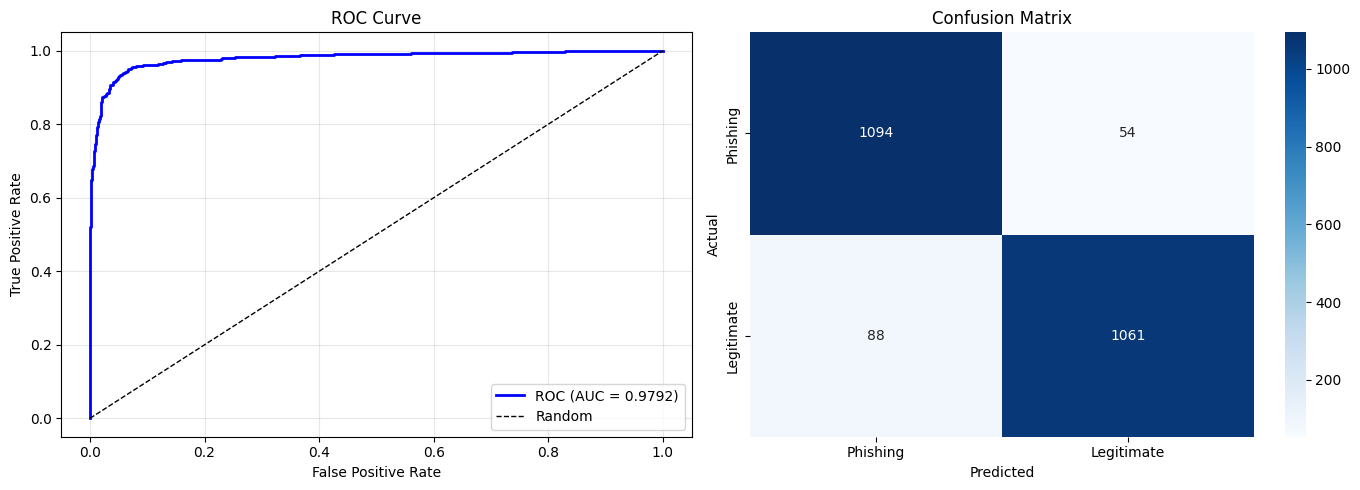

In [75]:
# ===== 10) ROC 커브 및 Confusion Matrix 시각화 =====
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

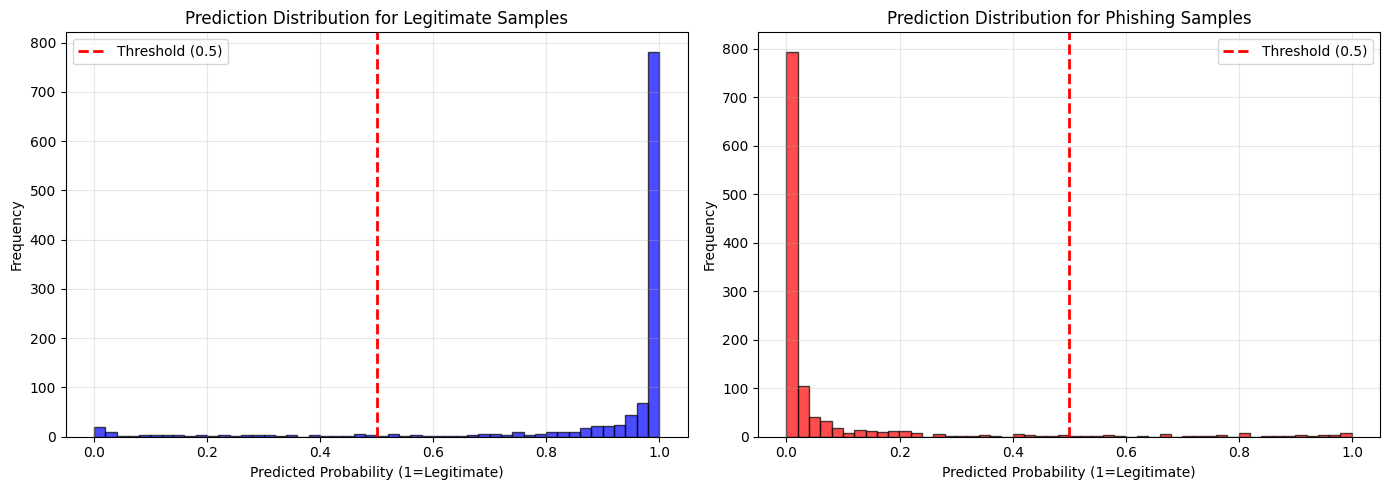


정상 사이트 평균 예측값: 0.9064
피싱 사이트 평균 예측값: 0.0682


In [76]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


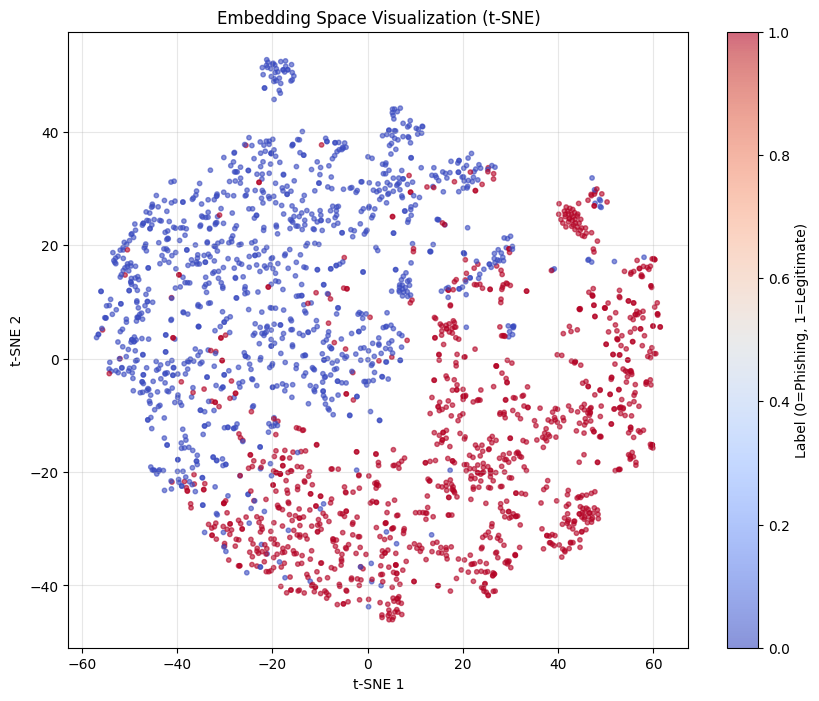

In [77]:
# ===== 12) 임베딩 공간 시각화 (t-SNE) =====
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Label (0=Phishing, 1=Legitimate)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.grid(True, alpha=0.3)
plt.show()

In [78]:
# ===== 13) 모델 저장 (Keras 모델 + Scaler) =====
# ⭐ Chaquopy를 사용하여 코틀린에서 직접 케라스 모델 로드

import os
import gc
import json

# 메모리 정리 (크래시 방지)
gc.collect()
keras.backend.clear_session()

# 🔧 Linux 환경 경로
OUTPUT_DIR = "/home/wza/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "classifier_model.keras")  # .keras 형식 권장
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler_params.json")

# 1) Keras 모델 저장 (.keras 형식 - TF 2.15 권장)
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("✅ Keras 모델 저장 완료!")
print(f"   크기: {os.path.getsize(CLASSIFIER_PATH) / 1024 / 1024:.2f} MB")

# 2) Scaler 파라미터 저장 (Android 전처리용)
print(f"\nScaler 파라미터 저장 중: {SCALER_PATH}")
with open(SCALER_PATH, 'w') as f:
    json.dump(scaler_params, f, indent=2)
print("✅ Scaler 파라미터 저장 완료!")

print("\n" + "=" * 60)
print("✅ 모델 저장 완료 (Chaquopy용 준비됨)")
print("=" * 60)
print("\n📱 Android Chaquopy 사용법:")
print("   1. build.gradle에 Chaquopy 추가")
print("   2. classifier_model.keras를 assets에 복사")
print("   3. scaler_params.json을 assets에 복사")
print("   4. Python 모듈에서 모델 로드 후 추론")
print("=" * 60)

Classifier 모델 저장 중: /home/wza/YU_mobile_kotlin/phishing/classifier_model.keras
✅ Keras 모델 저장 완료!
   크기: 0.78 MB

Scaler 파라미터 저장 중: /home/wza/YU_mobile_kotlin/phishing/scaler_params.json
✅ Scaler 파라미터 저장 완료!

✅ 모델 저장 완료 (Chaquopy용 준비됨)

📱 Android Chaquopy 사용법:
   1. build.gradle에 Chaquopy 추가
   2. classifier_model.keras를 assets에 복사
   3. scaler_params.json을 assets에 복사
   4. Python 모듈에서 모델 로드 후 추론


## 🔧 TFLite 변환 문제 해결: from_keras_model 직접 변환

**문제 원인:**
- `classifier.export()` → `from_saved_model()` 방식은 Keras 3에서 BatchNormalization의 `moving_mean/variance`가 제대로 전달되지 않을 수 있음
- TFLite 출력이 ~0.5로 수렴하는 것은 BatchNorm이 "학습 모드"처럼 동작하거나 통계가 손실된 증거

**해결책:**
- `tf.lite.TFLiteConverter.from_keras_model(classifier)`로 직접 변환
- SavedModel 중간 단계를 거치지 않아 BatchNorm 통계가 정확히 유지됨

In [25]:
# # ===== 14) TFLite 모델 테스트 =====
# import numpy as np
# import tensorflow as tf

# # ⭐ 중요: TFLite 파일을 새로 로드 (이전 interpreter 재사용 방지)
# TFLITE_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_classifier.tflite"

# print(f"TFLite 모델 로드: {TFLITE_PATH}")
# interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print(f"입력 shape: {input_details[0]['shape']}")
# print(f"입력 dtype: {input_details[0]['dtype']}")
# print(f"출력 shape: {output_details[0]['shape']}")

# # 테스트 샘플 준비
# test_sample = X_test_scaled[0:20].astype(np.float32)
# batch_size = test_sample.shape[0]

# # TFLite는 보통 [1, input_dim] 형태이므로 샘플별로 추론
# print(f"\n샘플 {batch_size}개에 대해 추론 수행...")

# tflite_outputs = []
# for i in range(batch_size):
#     sample = test_sample[i:i+1].astype(np.float32)
#     interpreter.set_tensor(input_details[0]['index'], sample)
#     interpreter.invoke()
#     output = interpreter.get_tensor(output_details[0]['index'])
#     tflite_outputs.append(output[0][0])

# tflite_output = np.array(tflite_outputs).reshape(-1, 1)

# # ⭐ 변환에 썼던 classifier 그대로 사용 (메모리 모델로 정확한 비교)
# keras_output = classifier.predict(test_sample, verbose=0)

# # 결과 비교
# print("\n" + "=" * 60)
# print("===== TFLite vs Keras 출력 비교 =====")
# print("=" * 60)

# for i in range(batch_size):
#     actual = "정상" if y_test[i] == 1 else "피싱"
#     diff = abs(tflite_output[i][0] - keras_output[i][0])
#     match = "✅" if diff < 0.01 else "❌"
#     print(f"샘플 {i+1}: TFLite={tflite_output[i][0]:.6f}, Keras={keras_output[i][0]:.6f}, 차이={diff:.6f} {match}, 실제={actual}")

# # 통계
# mae = np.mean(np.abs(tflite_output - keras_output))
# max_err = np.max(np.abs(tflite_output - keras_output))
# print(f"\n📊 통계:")
# print(f"   평균 절대 오차 (MAE): {mae:.6f}")
# print(f"   최대 오차: {max_err:.6f}")

# if max_err < 0.001:
#     print("\n🎉 TFLite와 Keras 출력이 거의 동일합니다! (오차 < 0.001)")
# elif max_err < 0.01:
#     print("\n✅ TFLite와 Keras 출력이 매우 유사합니다. (오차 < 0.01)")
# else:
#     print(f"\n⚠️ TFLite와 Keras 출력에 차이가 있습니다. (최대 오차: {max_err:.4f})")
#     print("   → 모델을 다시 변환하거나, 커널을 재시작 후 처음부터 실행해보세요.")

In [ ]:
# ===== 14) Android assets 폴더로 복사 =====
import shutil

# 🔧 Linux 환경 경로
ANDROID_ASSETS = "/home/wza/YU_mobile_kotlin/app/src/main/assets"

# Keras 모델 복사
shutil.copy(CLASSIFIER_PATH, os.path.join(ANDROID_ASSETS, "classifier_model.keras"))

# Scaler 파라미터 복사 (Android 전처리용)
shutil.copy(SCALER_PATH, os.path.join(ANDROID_ASSETS, "scaler_params.json"))

print("✅ Android assets 폴더로 복사 완료!")
print(f"   {os.path.join(ANDROID_ASSETS, 'classifier_model.keras')}")
print(f"   {os.path.join(ANDROID_ASSETS, 'scaler_params.json')}")

# 최종 요약
print("\n" + "="*60)
print("✅ 피싱 분류 모델 생성 완료 (Chaquopy용)")
print("="*60)
print(f"\n📊 성능:")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Test AUC: {test_auc:.4f}")
print(f"\n📁 저장된 파일:")
print(f"   - classifier_model.keras ({os.path.getsize(CLASSIFIER_PATH) / 1024 / 1024:.2f} MB)")
print(f"   - scaler_params.json (입력 표준화용)")
print(f"\n📱 Chaquopy 사용법:")
print(f"   - 입력: {input_dim}개 피처 (float32)")
print("   - ⚠️ 입력 전처리: scaler_params.json의 mean/std로 표준화 필요!")
print("     scaled_x = (x - mean) / std")
print("   - 출력: 1개 값 (0.0~1.0)")
print("   - 해석: 0에 가까우면 정상, 1에 가까우면 피싱")
print("="*60)